# Final Report and Summary of Analysis: AI Scout for Improved Player Evaluation

#### CONTENTS

    I. Purpose
    II. Data
    III. Modeling
    IV. Conclusions
    V. Recommendations
    VI. Next Steps

In [110]:
# Imports
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from src import model_functions as mf
from src import data_cleaning as dc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## I. Purpose

Prior to last season the NBA launched the G-League to develop players coming out of high school that choose not to go to college. With this new opportunity to sign players out of high school, new development strategies are being implemented and knowing when to pull the plug on a player, and who to draft in order to fill out your roster. Using standard and advanced metrics, I’m creating an AI Scout for NBA general managers that predicts the probability of a prospect becoming a specific player type of the modern league given past performance and their physical characteristics. 

#### Goals:
- Use advanced metrics to better classify modern NBA player roles. 
- Using this new lens, develop a machine learning model to predict a young player's potential NBA classification or player role as they develop. 

With this tool, scouts and front office executives would have a better understanding of a young player's potential career trajectory, track that player's development progress year over year, and help make decisions on contract commitments.

## II. Data

Descriptions of the statistical categories used can be found in the `readme` file of the `data` folder. 

In order to classify modern nba players, this project uses advanced metrics that take advantage of player tracking and play-by-play data that isn’t available in traditional box scores.

- NBA Advanced Metrics from FiveThirtyEight Sports [`repository link`](https://github.com/fivethirtyeight/nba-player-advanced-metrics)

We'll use historical college statistics of our newly classified modern nba players in order to create the prediction model. Cross Validation will be used to train and test the model. 

- NCAA College statistics are available from [basketball-reference.com](https://basketball-reference.com). The dataset used in this project was obtained through [barttorvik.com](https://barttorvik.com)

#### Import Data

In [15]:
import sqlite3

pd.set_option('display.max_columns', 500)

conn = sqlite3.connect('../../notebooks/exploratory/AI_SCOUT.db')

In [118]:
mod_data = pd.read_sql(
    """
    SELECT * FROM MODERN_NBA
    """, conn)
mod_data.head()

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
0,youngtr01,Trae Young,2020,21,PG,ATL,-7.6,ATL,60,2120,65.1,35.3,29.3,59.5,9.2,4.2,1.2,4.8,7.1,-3.5,3.6,7.0,17.0,15.4,34.9,45.6,16.2,1.6,11.5,6.5,1.4,0.3,113.6,36.1,117.2,50.1,36.1,86.0,45.5,44.8
1,huntede01,De'Andre Hunter,2020,22,SF,ATL,-7.6,ATL,63,2018,62.0,32.0,13.5,52.1,1.9,5.0,1.1,1.8,-2.5,-1.3,-3.8,-1.1,5.9,4.7,17.5,8.0,12.1,2.3,13.1,7.6,1.0,0.7,99.5,16.9,117.3,45.4,35.5,76.4,44.5,21.1
2,huertke01,Kevin Huerter,2020,21,SG,ATL,-7.6,ATL,56,1760,54.1,31.4,13.6,53.6,4.2,4.5,1.5,1.7,-0.4,-2.4,-2.8,-0.1,8.0,8.1,17.1,17.5,12.0,2.1,12.0,7.0,1.4,1.3,107.1,17.2,116.5,45.3,38.0,82.8,54.8,10.5
3,reddica01,Cam Reddish,2020,20,SF,ATL,-7.6,ATL,58,1551,47.6,26.7,13.7,50.0,2.0,4.9,2.0,2.2,-2.8,-0.1,-3.0,-0.2,5.9,5.0,18.9,8.0,13.6,2.4,12.7,7.5,1.9,1.5,94.7,18.3,115.0,42.8,33.2,80.2,45.1,22.7
4,collijo01,John Collins,2020,22,PF,ATL,-7.6,ATL,41,1363,41.9,33.2,22.7,65.9,1.5,10.7,2.5,1.9,0.0,-0.3,-0.3,1.7,15.6,17.1,22.7,7.6,10.1,9.0,24.0,16.4,1.1,4.1,123.7,21.6,112.2,64.2,40.1,80.0,24.3,24.8


In [17]:
old_data = pd.read_sql(
    """
    SELECT * FROM RAPTOR
    WHERE year_id BETWEEN 1990 AND 2000
    AND G > 35;
    """, conn)
old_data.head()

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
0,mutomdi01,Dikembe Mutombo,2000,33,C,ATL,-5.8,ATL,82,2984,75.2,36.4,12.4,62.1,1.4,15.2,3.9,2.3,0.1,1.2,1.3,6.2,14.9,17.3,13.8,5.4,18.7,11.2,31.3,21.2,0.5,5.9,116.1,14.9,100.7,56.2,NaN,70.8,0.0,73.5
1,hendeal01,Alan Henderson,2000,27,PF,ATL,-5.8,ATL,82,2775,70.0,33.8,15.3,50.3,1.1,8.1,1.9,2.0,-0.7,-0.5,-1.2,2.3,8.2,9.4,19.4,4.6,11.4,10.5,12.1,11.3,1.5,1.3,104.5,19.3,108.5,46.5,10.0,67.1,1.1,35.9
2,jacksji01,Jim Jackson,2000,29,SF,ATL,-5.8,ATL,79,2767,69.8,35.0,18.7,49.6,3.3,5.6,1.0,2.6,0.2,-1.7,-1.5,1.8,9.6,7.8,24.2,14.5,12.2,4.0,11.6,7.8,1.1,0.2,101.1,23.3,110.4,41.8,38.6,87.7,24.5,17.2
3,rideris01,Isaiah Rider,2000,28,SG,ATL,-5.8,ATL,60,2084,52.5,34.7,21.8,48.8,4.1,4.9,0.9,3.2,0.2,-2.5,-2.3,0.5,10.0,6.7,28.8,19.4,12.4,3.3,10.2,6.8,1.0,0.2,99.2,27.7,111.0,44.1,31.1,78.5,16.8,24.3
4,colesbi01,Bimbo Coles,2000,31,PG,ATL,-5.8,ATL,80,1924,48.5,24.1,13.2,49.4,5.9,3.5,1.4,2.1,-0.1,-1.5,-1.6,1.1,8.5,7.1,17.4,24.6,13.6,1.7,8.1,4.9,1.6,0.4,104.4,17.9,110.3,47.2,20.5,81.7,6.4,17.1


In [19]:
ncaa_data = pd.read_sql(
    """
    SELECT * FROM NCAA
    """, conn)
ncaa_data.head()

,Pick,Class,Height,Player,Team,Conf,G,Role,BPM,ORtg,Usg,eFG,TS,OR,DR,Ast,TO,A/TO,Blk,Stl,FTR,Far2A,Far2M,Far2%,FTA,FTM,FT%,2P%,3PA,3PM,3P%,Year
0,1,Fr,82,Blake Griffin,Oklahoma,B12,33,None,8.0,109.8,28.6,56.8,58.0,13.9,24.0,16.7,17.4,0.8,3.4,2.2,60.8,116,197,0.589,184,322,0.571,0.6,0,2,0.000,2008
1,1,Fr,75,Derrick Rose,Memphis,CUSA,40,None,9.5,112.2,26.8,51.7,56.0,5.0,11.7,30.4,19.2,1.8,1.3,2.3,47.0,146,205,0.712,173,332,0.521,23.9,35,104,0.337,2008
2,2,Fr,81,Michael Beasley,Kansas St.,B12,32,None,14.9,119.8,33.3,56.0,60.8,13.0,30.0,8.7,15.3,0.4,5.6,2.3,48.7,211,272,0.776,260,466,0.558,16.5,35,92,0.380,2008
3,2,Fr,79,Evan Turner,Ohio St.,B10,37,None,3.4,96.0,20.8,51.9,55.7,4.1,13.8,18.4,29.0,1.0,2.2,2.9,44.4,72,103,0.699,86,163,0.528,29.7,23,69,0.333,2008
4,2,So,87,Hasheem Thabeet,Connecticut,BE,33,None,6.9,115.7,15.9,60.3,64.3,11.1,14.9,2.2,20.2,0.2,12.9,0.5,89.4,118,169,0.698,114,189,0.603,0.0,0,0,0.000,2008


#### Data Cleaning

In [22]:
old_df = dc.clean_df(old_data, None)
old_df.head()

,age,pos,tmRtg,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
1,27,PF,-5.8,82,2775,70.0,33.8,15.3,50.3,1.1,8.1,1.9,2.0,-0.7,-0.5,-1.2,2.3,8.2,9.4,19.4,4.6,11.4,10.5,12.1,11.3,1.5,1.3,104.5,19.3,108.5,46.5,10.0,67.1,1.1,35.9
2,29,SF,-5.8,79,2767,69.8,35.0,18.7,49.6,3.3,5.6,1.0,2.6,0.2,-1.7,-1.5,1.8,9.6,7.8,24.2,14.5,12.2,4.0,11.6,7.8,1.1,0.2,101.1,23.3,110.4,41.8,38.6,87.7,24.5,17.2
3,28,SG,-5.8,60,2084,52.5,34.7,21.8,48.8,4.1,4.9,0.9,3.2,0.2,-2.5,-2.3,0.5,10.0,6.7,28.8,19.4,12.4,3.3,10.2,6.8,1.0,0.2,99.2,27.7,111.0,44.1,31.1,78.5,16.8,24.3
4,31,PG,-5.8,80,1924,48.5,24.1,13.2,49.4,5.9,3.5,1.4,2.1,-0.1,-1.5,-1.6,1.1,8.5,7.1,17.4,24.6,13.6,1.7,8.1,4.9,1.6,0.4,104.4,17.9,110.3,47.2,20.5,81.7,6.4,17.1
5,22,PG,-5.8,81,1888,47.6,23.3,13.7,49.7,7.2,3.4,2.1,3.2,0.4,-0.7,-0.3,2.4,9.7,8.6,19.2,29.3,19.1,1.4,8.2,4.8,2.5,0.3,99.6,20.2,108.4,45.8,29.3,80.7,26.2,23.3


In [38]:
mod_df = dc.clean_df(mod_data, None)
mod_df.head()

,age,pos,tmRtg,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
0,21,PG,-7.6,60,2120,65.1,35.3,29.3,59.5,9.2,4.2,1.2,4.8,7.1,-3.5,3.6,7.0,17.0,15.4,34.9,45.6,16.2,1.6,11.5,6.5,1.4,0.3,113.6,36.1,117.2,50.1,36.1,86.0,45.5,44.8
1,22,SF,-7.6,63,2018,62.0,32.0,13.5,52.1,1.9,5.0,1.1,1.8,-2.5,-1.3,-3.8,-1.1,5.9,4.7,17.5,8.0,12.1,2.3,13.1,7.6,1.0,0.7,99.5,16.9,117.3,45.4,35.5,76.4,44.5,21.1
2,21,SG,-7.6,56,1760,54.1,31.4,13.6,53.6,4.2,4.5,1.5,1.7,-0.4,-2.4,-2.8,-0.1,8.0,8.1,17.1,17.5,12.0,2.1,12.0,7.0,1.4,1.3,107.1,17.2,116.5,45.3,38.0,82.8,54.8,10.5
3,20,SF,-7.6,58,1551,47.6,26.7,13.7,50.0,2.0,4.9,2.0,2.2,-2.8,-0.1,-3.0,-0.2,5.9,5.0,18.9,8.0,13.6,2.4,12.7,7.5,1.9,1.5,94.7,18.3,115.0,42.8,33.2,80.2,45.1,22.7
4,22,PF,-7.6,41,1363,41.9,33.2,22.7,65.9,1.5,10.7,2.5,1.9,0.0,-0.3,-0.3,1.7,15.6,17.1,22.7,7.6,10.1,9.0,24.0,16.4,1.1,4.1,123.7,21.6,112.2,64.2,40.1,80.0,24.3,24.8


## III. Model Creation

    1. Positionality Exploration Across Eras
        a. Build
        b. Evaluate
    2. Cluster 
        a. Scale
        b. Dimensionality Reduction
            i. PCA
            ii. LDA
        c. Feature Consolidation
        d. Build
        e. Evaluate
    3. Label Identification and Understanding
    4. Prepare NCAA dataset with target labels
    5. Prediction Model
        a. Build
        b. Evaluate

#### 1. Positionality Exploration Across Eras

- ##### 1a. Build

In [23]:
# 90's ERA
# Define X and y
X = old_df.drop(columns=['pos'], axis = 1)
y = old_df['pos']

In [57]:
model, X_test, y_test, y_hat_test, y_hat_proba = mf.lrm(X, y, 23)

In [39]:
# MODERN ERA
# Define X and y
X2 = mod_df.drop(columns = ['pos'], axis = 1)
y2 = mod_df['pos']

In [58]:
model2, X2_test, y2_test, y2_hat_test, y2_hat_proba = mf.lrm(X2, y2, 23)

- ##### 1b. Evaluate

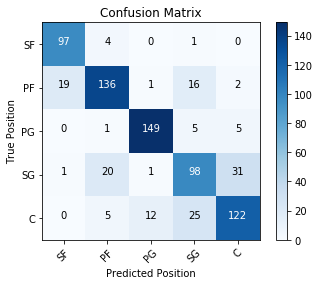

 recall:  0.8113497298200217 
 precision:  0.8001618871813868


In [73]:
# 90's ERA
cnf_matrix = confusion_matrix(y_test, y_hat_test)
recall, precision = mf.show_cm(cnf_matrix, y)

In [70]:
# 90's ERA Cross Validation
predicted = cross_val_predict(model, X, y, cv=10)
print (metrics.classification_report(y, predicted))

              precision    recall  f1-score   support

           C       0.82      0.87      0.85       450
          PF       0.77      0.76      0.77       632
          PG       0.88      0.89      0.88       662
          SF       0.69      0.61      0.65       637
          SG       0.65      0.71      0.68       622

    accuracy                           0.76      3003
   macro avg       0.76      0.77      0.77      3003
weighted avg       0.76      0.76      0.76      3003



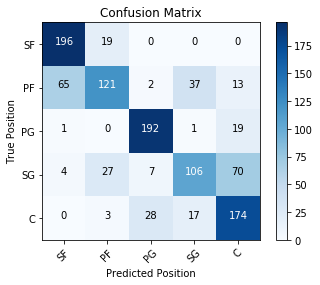

 recall:  0.720110121122606 
 precision:  0.7151709269040324


In [49]:
# MODERN ERA
cnf_matrix2 = confusion_matrix(y2_test, y2_hat_test)
recall2, precision2 = mf.show_cm(cnf_matrix2, y2)

In [71]:
# MODERN ERA Cross Validation
predicted2 = cross_val_predict(model2, X2, y2, cv=10)
print (metrics.classification_report(y2, predicted2))

              precision    recall  f1-score   support

           C       0.76      0.86      0.81       858
          PF       0.65      0.53      0.58       890
          PG       0.82      0.89      0.86       861
          SF       0.58      0.48      0.53       827
          SG       0.65      0.71      0.67       972

    accuracy                           0.70      4408
   macro avg       0.69      0.70      0.69      4408
weighted avg       0.69      0.70      0.69      4408



#### 2. Cluster Modeling

In [74]:
from src import cluster_functions as cf

In [90]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X2)

- ##### Dimensionality Reduction

In [91]:
pca = PCA(n_components=2)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
print("Cumulative Explained Variance:", pca.explained_variance_ratio_.sum())

Cumulative Explained Variance: 0.4965935393930007


In [92]:
LDA = LinearDiscriminantAnalysis(n_components=2, 
                                 shrinkage='auto', 
                                 solver='eigen')

In [95]:
LDA_reduced_df = LDA.fit(X_scaled,y2).transform(X_scaled)
LDA.score(X_scaled,y2)

0.7044010889292196

The LDA explaind variance at 70% is initially much higher than a 2 component PCA reduction. Lets see how well the clusters can differentiate.

2 0.5006799491942199
3 0.5118463338901772
4 0.43165904430868296
5 0.38570952405595477
6 0.36671789329902227
7 0.34716711035128217
8 0.3242681556355149
9 0.331994568767971
10 0.33621307196235617
11 0.33407270891246454
12 0.32139548670056517
13 0.32774394882115526
14 0.3268978287724816
15 0.3270515857799974
16 0.32595573295798086
17 0.3260928931226231
18 0.32408227119293337
19 0.32232772891342276


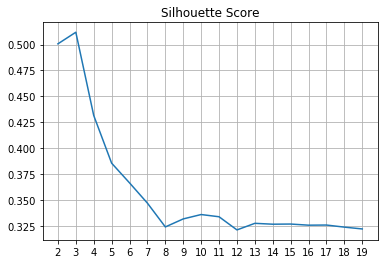

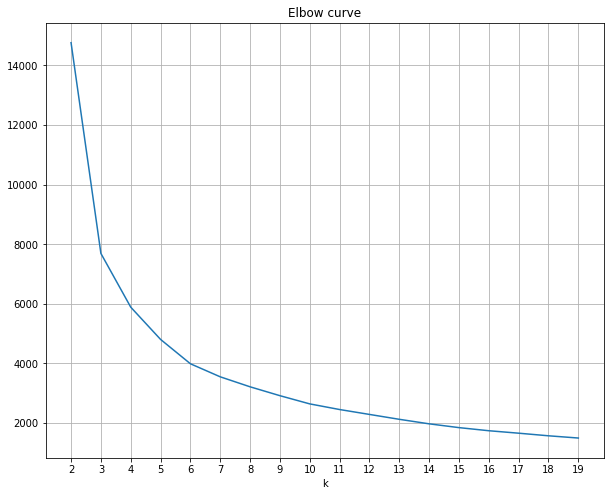

In [96]:
cf.find_best_cluster(LDA_reduced_df,2,20)

There doesn't seem to be definitive elbow, and the best bump in silouette score visually comes at 9 components, although the increase is small. 

In [100]:
k_means = cf.kmeans(LDA_reduced_df, 9)

In [101]:
# Assign labels
# data['Cluster'] = k_means['labels']
# mod_data['Cluster'] = cf.k_means['labels']

# Print silhouette score
print ("silhouette score:", k_means['silhouette_score'])

silhouette score: 0.331994568767971


Lets use cross validation to see if there is a definitive number of components in pca to use

Best parameter (CV score=0.922):
{'logistic__C': 21.54434690031882, 'pca__n_components': 38}


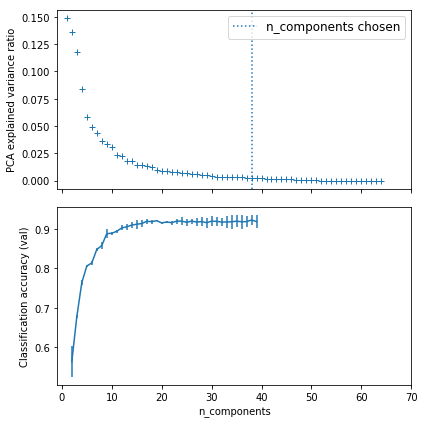

In [99]:
mf.dim_red(X_scaled, y2, 23)

38 components does not reduce our dimensionality. Lets look into the features and see if we can eliminate redundant columns.

- ##### Feature Consolidation

In [103]:
X_new = mod_df[['Raptor+/-', 'Raptor D','Raptor O','TS%','PIE%','ORtg','%Pos','3P%', '3PAr', 'FTAr', 'AST%', 'USG%', '2P%']]
y_new = mod_df['pos']

In [104]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X_new)

In [105]:
pca = PCA(n_components=3)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
print("Cumulative Explained Variance:", pca.explained_variance_ratio_.sum())

Cumulative Explained Variance: 0.7394563595569943


In [106]:
LDA_reduced_df = LDA.fit(X_scaled,y_new).transform(X_scaled)
LDA.score(X_scaled,y_new)

0.6320326678765881

2 0.26712323766075197
3 0.2914239434035136
4 0.28249027697271883
5 0.26821722502739703
6 0.27750740005767505
7 0.26162187529753594
8 0.25347327454756063
9 0.2496601629806081
10 0.2475605199947332
11 0.24770677843324393
12 0.24947139590626294
13 0.24671158929723302
14 0.24203722306259232
15 0.24484483802997314
16 0.2435910436243844
17 0.24199874069744925
18 0.24165459979389992
19 0.23771664577106774


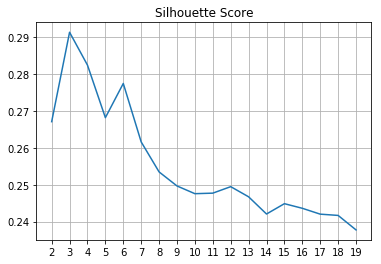

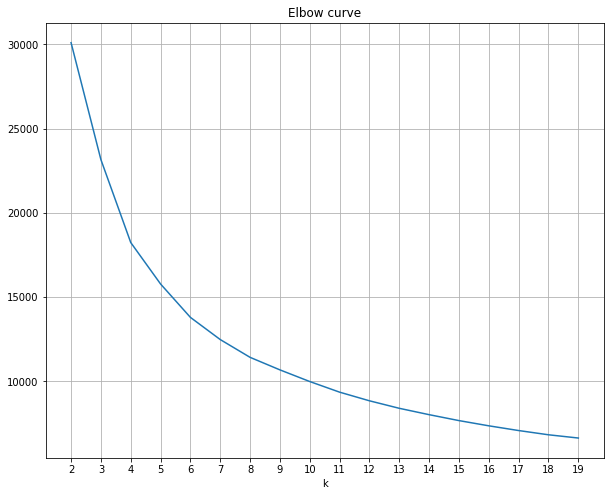

In [108]:
cf.find_best_cluster(X_pca,2,20)

While the elbow at 6 components is slight, there is a clear peak in silouette score. Lets build a Gaussian Mixture Model using 6 clusters. 

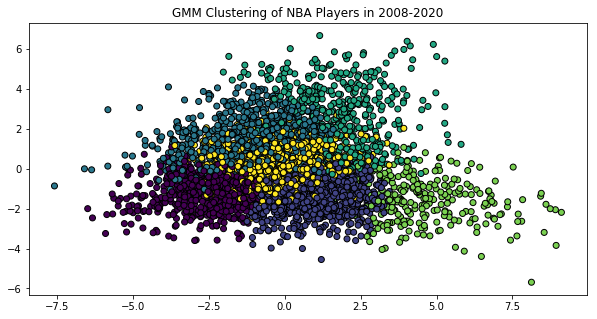

In [119]:
from sklearn.mixture import GaussianMixture
from matplotlib.ticker import MaxNLocator
fig = plt.figure(figsize = (10, 5))
gmm = GaussianMixture(n_components=6).fit(X_pca)
labels = gmm.predict(X_pca)
mod_data['gmm_cluster'] = labels
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', edgecolor='black')
plot_title="GMM Clustering of NBA Players in 2008-2020"
plt.title(plot_title);

In [121]:
#Find the probability of each row belonging to a cluster
probs = np.round(gmm.predict_proba(X_pca)*100, 4)
# mod_data['prob'] = probs
print(labels,probs)

[4 0 5 ... 0 2 0] [[0.00000e+00 7.75000e-02 0.00000e+00 2.80000e-03 9.99197e+01 0.00000e+00]
 [6.08811e+01 6.60310e+00 4.80000e-03 1.29600e-01 5.58000e-02 3.23256e+01]
 [3.41265e+01 1.21962e+01 0.00000e+00 3.23000e-02 4.60000e-02 5.35989e+01]
 ...
 [7.34480e+01 1.86739e+01 5.67300e-01 4.88100e-01 4.61000e-01 6.36180e+00]
 [1.34089e+01 7.10000e-03 8.62491e+01 1.13700e-01 4.52000e-02 1.76000e-01]
 [9.56021e+01 1.96970e+00 1.05600e-01 5.65000e-02 3.20000e-02 2.23410e+00]]


In [122]:
prob_df = pd.DataFrame(data=probs, columns=["c0","c1","c2","c3","c4","c5"])
prob_df.head()

,c0,c1,c2,c3,c4,c5
0,0.0000,0.0775,0.0000,0.0028,99.9197,0.0000
1,60.8811,6.6031,0.0048,0.1296,0.0558,32.3256
2,34.1265,12.1962,0.0000,0.0323,0.0460,53.5989
3,74.3223,7.2928,0.0292,0.1560,0.0819,18.1179
4,1.0540,11.1951,0.5975,45.5912,14.0604,27.5018


In [130]:
gmm_df=pd.concat([mod_data, prob_df], axis=1)
gmm_df.head()

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,gmm_cluster,c0,c1,c2,c3,c4,c5
0,youngtr01,Trae Young,2020,21,PG,ATL,-7.6,ATL,60,2120,65.1,35.3,29.3,59.5,9.2,4.2,1.2,4.8,7.1,-3.5,3.6,7.0,17.0,15.4,34.9,45.6,16.2,1.6,11.5,6.5,1.4,0.3,113.6,36.1,117.2,50.1,36.1,86.0,45.5,44.8,4,0.0000,0.0775,0.0000,0.0028,99.9197,0.0000
1,huntede01,De'Andre Hunter,2020,22,SF,ATL,-7.6,ATL,63,2018,62.0,32.0,13.5,52.1,1.9,5.0,1.1,1.8,-2.5,-1.3,-3.8,-1.1,5.9,4.7,17.5,8.0,12.1,2.3,13.1,7.6,1.0,0.7,99.5,16.9,117.3,45.4,35.5,76.4,44.5,21.1,0,60.8811,6.6031,0.0048,0.1296,0.0558,32.3256
2,huertke01,Kevin Huerter,2020,21,SG,ATL,-7.6,ATL,56,1760,54.1,31.4,13.6,53.6,4.2,4.5,1.5,1.7,-0.4,-2.4,-2.8,-0.1,8.0,8.1,17.1,17.5,12.0,2.1,12.0,7.0,1.4,1.3,107.1,17.2,116.5,45.3,38.0,82.8,54.8,10.5,5,34.1265,12.1962,0.0000,0.0323,0.0460,53.5989
3,reddica01,Cam Reddish,2020,20,SF,ATL,-7.6,ATL,58,1551,47.6,26.7,13.7,50.0,2.0,4.9,2.0,2.2,-2.8,-0.1,-3.0,-0.2,5.9,5.0,18.9,8.0,13.6,2.4,12.7,7.5,1.9,1.5,94.7,18.3,115.0,42.8,33.2,80.2,45.1,22.7,0,74.3223,7.2928,0.0292,0.1560,0.0819,18.1179
4,collijo01,John Collins,2020,22,PF,ATL,-7.6,ATL,41,1363,41.9,33.2,22.7,65.9,1.5,10.7,2.5,1.9,0.0,-0.3,-0.3,1.7,15.6,17.1,22.7,7.6,10.1,9.0,24.0,16.4,1.1,4.1,123.7,21.6,112.2,64.2,40.1,80.0,24.3,24.8,3,1.0540,11.1951,0.5975,45.5912,14.0604,27.5018


- ##### Label Clusters

*C0*:
Two-way long distance shooters, generally not the first scoring option, but accurate from deep.
- Ray Allen
- Danny Green
- JJ Redick
- Kyle Korver

In [132]:
C0_data = pd.read_sql(
    """
    SELECT * FROM CLUSTERS_4
    WHERE gmm_cluster=0
    ORDER BY "c0" DESC
    """, conn)

In [139]:
fi0 = cf.feature_importance(C0_data, mod_df, 3).reset_index().drop('index', axis=1)
fi0

,Feature,Importance,Cluster Average,League Average
0,PIE%,0.452534,8.200863,9.413770
1,Raptor O,0.416377,-0.217647,-0.437636
2,TS%,0.350064,55.521412,53.956942
3,ORtg,0.343079,110.231137,107.406624
4,%Pos,0.330918,15.786118,19.028335
5,Raptor+/-,0.315331,-0.233725,-0.499660
6,USG%,0.314517,16.087765,19.035345
7,3P%,0.156274,37.476471,28.084959
8,AST%,0.141299,10.448314,13.661025
9,2P%,0.128481,49.714353,48.971892


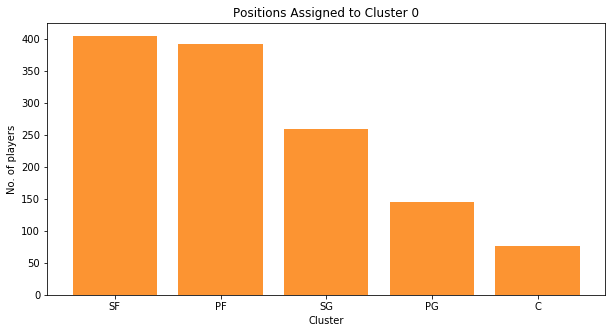

In [140]:
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 

plt.bar(C0_data['pos'].unique(), C0_data['pos'].value_counts(), color ='#fc9432') 
  
plt.xlabel("Cluster") 
plt.ylabel("No. of players") 
plt.title("Positions Assigned to Cluster 0") 
plt.show() 

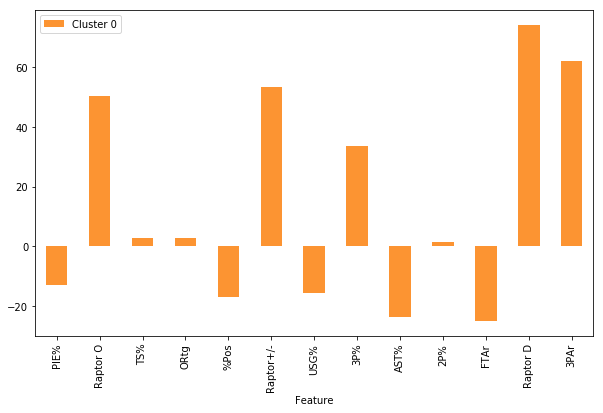

In [143]:
cf.bar_features(fi0, 'Cluster 0', '#fc9432')

*C1*:
Perimeter role player, 3pt spot up shooters, defensive liability

*C2*:
Close to the rim, defensive minded bigs. No outside shot, but gets to the free throw line often. 
- Kendrick Perkins

*C3*:
Versatile sharp-shooters, generally a higher % of shots come from long-distance. C4 potential but can be lacking on defense. Can create offense for themselves and teammates. Poor man's C4. 
- Kyle Lowry
- Jamal Crawford
- Deron Williams
- Tony Parker

*C4*:
No weakness, 2-way players, create offense for themselves and teammates. 1st option, max contract players. 
Build your team around superstars
- Steph Curry
- Lebron
- Nikola Jokic
- Kevin Durant

*C5*:
Traditional center mold, or PF without range, but a knack for scoring around the rim. Rebounders. 
- Dwight Howard
- Rudy Gobert
- Tyson Chandler

In [ ]:
conn.close()